### 机器学习方法——量化择时策略

In [1]:
DATASETS = [r"..\data\000001_daily_qfq.csv"]

TRAIN_START_DATE = "2023-01-01"
TRAIN_END_DATE = "2024-12-31"
VALID_START_DATE = "2025-01-01"
VALID_END_DATE = "2025-03-31"
TEST_START_DATE = "2025-04-01"
TEST_END_DATE = "2025-06-30"

TRAIN_FIELD = ["Open", "Close", "High", "Low", "Volume"]
TARGET_FIELD = "Open"

### 加载原始数据集

In [2]:
from ml.time.data_load import load_datasets

all_dfs = load_datasets(
    DATASETS,
    TRAIN_FIELD,
    TRAIN_START_DATE,
    TEST_END_DATE
)

display(all_dfs[0])

Loading datasets: 1it [00:00, 38.85it/s]

[Stock 0] ..\data\000001_daily_qfq.csv → (601, 5)


,Open,Close,High,Low,Volume
Date,,,,,
2023-01-03,11.59,12.16,12.24,11.44,2194128
2023-01-04,12.10,12.71,12.81,12.02,2189683
2023-01-05,12.79,12.87,13.13,12.76,1665425
2023-01-06,12.89,13.01,13.11,12.87,1195745
2023-01-09,13.14,13.19,13.27,12.91,1057659
...,...,...,...,...,...
2025-06-24,11.90,11.93,12.01,11.84,1308525
2025-06-25,11.93,12.06,12.08,11.83,1675116
2025-06-26,12.05,12.41,12.48,12.01,2174578


### 数据预处理

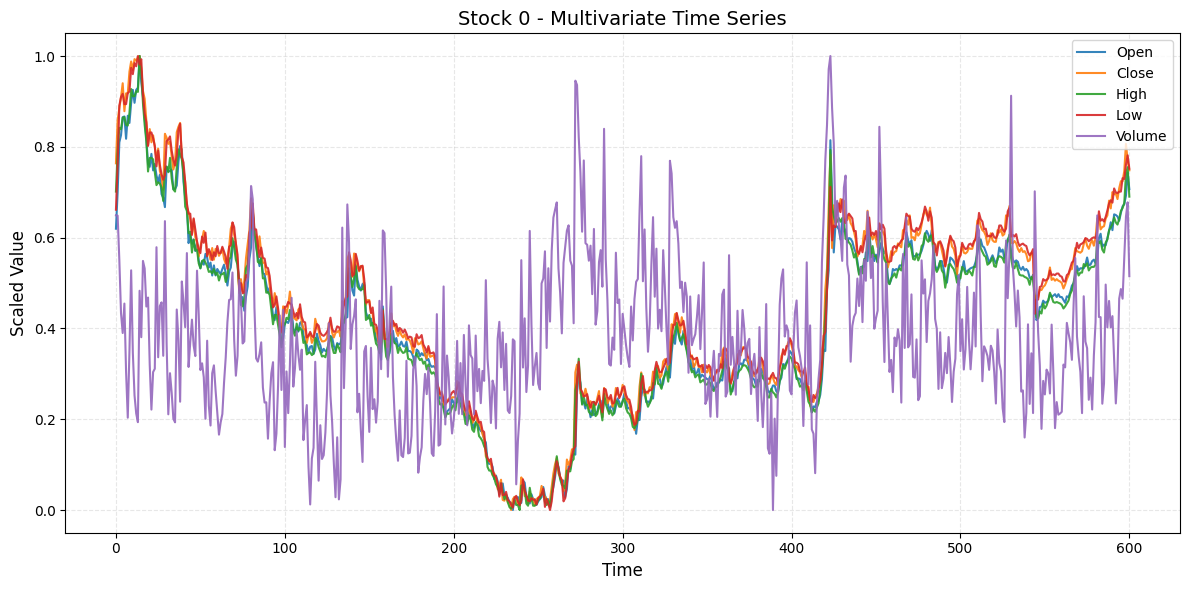

In [3]:
from ml.time.preprocess import apply_log_transform, scale_dataframe
from ml.time.utils import plot_multivariate_timeseries

for i, df in enumerate(all_dfs):
    df = apply_log_transform(df, columns=["Volume"])
    df = scale_dataframe(df, train_end_date=TRAIN_END_DATE)
    plot_multivariate_timeseries(df.values, TRAIN_FIELD, title=f"Stock {i} - Multivariate Time Series")
    all_dfs[i] = df

### 数据集划分

In [4]:
from ml.time.split import split_stock_data

X_train, X_valid, X_test, y_train, y_valid, y_test = split_stock_data(
    all_dfs=all_dfs,
    train_start_date=TRAIN_START_DATE,
    train_end_date=TRAIN_END_DATE,
    valid_start_date=VALID_START_DATE,
    valid_end_date=VALID_END_DATE,
    test_start_date=TEST_START_DATE,
    test_end_date=TEST_END_DATE,
    target_field=TARGET_FIELD,
    look_back_days=3,
)

[Stock 0]
  X_train: (482, 15), y_train: (482,)
  X_valid: (57, 15), y_valid: (57,)
  X_test:  (59, 15), y_test:  (59,)


### 模型训练和预测


===== [Stock 0] =====
Validation:
  MSE: 0.0001, MAE: 0.0040, R2: 0.8771
Test:
  MSE: 0.0001, MAE: 0.0048, R2: 0.9868


e:\miniconda\envs\train\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


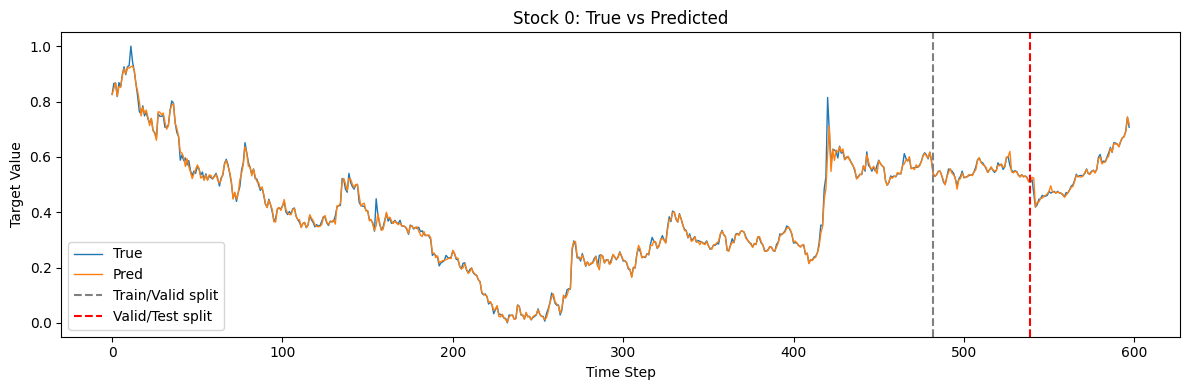

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def train_and_evaluate_models(X_train, y_train, X_valid, y_valid, X_test, y_test):
    """对每个stock分别训练"""
    n_stocks = len(X_train)
    
    for i in range(n_stocks):
        print(f"\n===== [Stock {i}] =====")

        # 模型训练
        model = LinearSVR(random_state=42, max_iter=10000)
        model.fit(X_train[i], y_train[i])

        # 各阶段预测
        y_pred_train = model.predict(X_train[i])
        y_pred_valid = model.predict(X_valid[i])
        y_pred_test  = model.predict(X_test[i])

        # 拼接所有结果
        y_true_all = np.concatenate([y_train[i], y_valid[i], y_test[i]])
        y_pred_all = np.concatenate([y_pred_train, y_pred_valid, y_pred_test])

        # 打印评估
        def print_metrics(split, y_true, y_pred):
            mse = mean_squared_error(y_true, y_pred)
            mae = mean_absolute_error(y_true, y_pred)
            r2  = r2_score(y_true, y_pred)
            print(f"{split}:")
            print(f"  MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")
        
        print_metrics("Validation", y_valid[i], y_pred_valid)
        print_metrics("Test", y_test[i], y_pred_test)

        # 可视化
        plt.figure(figsize=(12, 4))
        plt.plot(y_true_all, label="True", linewidth=1)
        plt.plot(y_pred_all, label="Pred", linewidth=1)
        plt.axvline(len(y_train[i]), color="gray", linestyle="--", label="Train/Valid split")
        plt.axvline(len(y_train[i]) + len(y_valid[i]), color="red", linestyle="--", label="Valid/Test split")
        plt.title(f"Stock {i}: True vs Predicted")
        plt.xlabel("Time Step")
        plt.ylabel("Target Value")
        plt.legend()
        plt.tight_layout()
        plt.show()
        

train_and_evaluate_models(X_train, y_train, X_valid, y_valid, X_test, y_test)

### 结果保存，用于回测

In [ ]:
# TODO:
# 1. 对数差分
# 2. 结果保存
# 3. 更多模型

raise NotImplementedError